# Modelo de detección de enfermedades de tiroides

## Carga de datos y simplificación de las categorías de la variable objetivo

Fuente del dataset: https://www.kaggle.com/datasets/emmanuelfwerr/thyroid-disease-data/data

In [2]:
import pandas as pd
file_path = "./data/thyroidDF.csv"
df = pd.read_csv(file_path)

# Simplify the target variable
class_mapping = {
    '-': 'negative',
    'K': 'hyperthyroid', 'B': 'hyperthyroid', 'H|K': 'hyperthyroid',
    'KJ': 'hyperthyroid', 'GI': 'hyperthyroid',
    'G': 'hypothyroid', 'I': 'hypothyroid', 'F': 'hypothyroid', 'C|I': 'hypothyroid',
    'E': 'negative', 'LJ': 'negative', 'D|R': 'negative',
}

df['target'] = df['target'].map(class_mapping)

# Drop rows with unmapped or missing target
df = df.dropna(subset=['target'])

# Check class distribution after mapping
print("Class distribution:")
print(df['target'].value_counts())


Class distribution:
target
negative        6774
hypothyroid      950
hyperthyroid     486
Name: count, dtype: int64


## Definición del problema

Pretendemos crear un modelo de clasificación que permita predecir si un paciente tiene o no una enfermedad de tiroides. Para ello, utilizaremos un conjunto de datos que contiene información sobre varios atributos de los pacientes, como la edad, el sexo, el nivel de la hormona estimulante de la tiroides (TSH), el nivel de la hormona tiroidea total (T3), el nivel de la hormona tiroidea libre (T4), entre otros.

Se ha decidido simplificar la variable objetivo, que originalmente tenía muchas categorías, en tres categorías: "hipotiroidismo", "negativo" e "hipertiroidismo". Esto se ha hecho para facilitar la interpretación del modelo y para reducir el desequilibrio de clases en la variable objetivo.

Crearemos por tanto un modelo de clasificación en estas 3 categorías. 

## Analisis exploratorio de los datos

Como ya se vio anteriorimente, la variable objetivo es "target", que tiene tres categorías: "hypothyroid", "negative" e "hyperthyroid", que no están balanceadas (la mayoría son casos negativos, lo cual es común en problemas de clasificación médica).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8210 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  8210 non-null   int64  
 1   sex                  7943 non-null   object 
 2   on_thyroxine         8210 non-null   object 
 3   query_on_thyroxine   8210 non-null   object 
 4   on_antithyroid_meds  8210 non-null   object 
 5   sick                 8210 non-null   object 
 6   pregnant             8210 non-null   object 
 7   thyroid_surgery      8210 non-null   object 
 8   I131_treatment       8210 non-null   object 
 9   query_hypothyroid    8210 non-null   object 
 10  query_hyperthyroid   8210 non-null   object 
 11  lithium              8210 non-null   object 
 12  goitre               8210 non-null   object 
 13  tumor                8210 non-null   object 
 14  hypopituitary        8210 non-null   object 
 15  psych                8210 non-null   object

Contamos con 8210 observaciones y 30 columnas.

La columna "patient_id" es un identificador único para cada paciente y no aporta información relevante para el análisis, por lo que se eliminará del conjunto de datos.

In [3]:
df.drop(columns=['patient_id', 'referral_source'], inplace=True)

Podemos ver que para algunas columnas existe la métrica (por ejemplo, 'TBG') y una columna adicional que indica si la métrica se tomó o no. Podemos comprobar que si la métrica no se tomó, el valor es 'nan'.


La mayoría de las columnas son no numéricas, por lo que se deberá realizar un proceso de codificación de variables categóricas para poder utilizarlas en el modelo.

In [4]:
object_columns = df.select_dtypes(exclude=['number']).columns

for col in object_columns:
    unique_values = df[col].unique()
    print(f"Columna '{col}': {unique_values}")

Columna 'sex': ['F' 'M' nan]
Columna 'on_thyroxine': ['f' 't']
Columna 'query_on_thyroxine': ['f' 't']
Columna 'on_antithyroid_meds': ['f' 't']
Columna 'sick': ['f' 't']
Columna 'pregnant': ['f' 't']
Columna 'thyroid_surgery': ['f' 't']
Columna 'I131_treatment': ['f' 't']
Columna 'query_hypothyroid': ['t' 'f']
Columna 'query_hyperthyroid': ['f' 't']
Columna 'lithium': ['f' 't']
Columna 'goitre': ['f' 't']
Columna 'tumor': ['f' 't']
Columna 'hypopituitary': ['f' 't']
Columna 'psych': ['f' 't']
Columna 'TSH_measured': ['t' 'f']
Columna 'T3_measured': ['f' 't']
Columna 'TT4_measured': ['f' 't']
Columna 'T4U_measured': ['f' 't']
Columna 'FTI_measured': ['f' 't']
Columna 'TBG_measured': ['f' 't']
Columna 'target': ['negative' 'hypothyroid' 'hyperthyroid']


Vemos que la mayoría de las columnas no numéricas son categóricas binarias con valores "f" y "t", que representan "falso" y "verdadero", respectivamente. Estas columnas se pueden convertir en variables binarias numéricas (0 y 1) para facilitar su uso en el modelo.

Para la columna 'sex', que tiene valores "M" y "F", se puede utilizar una codificación binaria (0 y 1) para representar el género también, pero como no hay un orden asociado y existen valores faltantes, se utilizará un enfoque de codificación one-hot para esta columna, dejando los valores faltantes a 0 en ambas columnas.

Vemos primero qué valores nan hay presentes.

In [5]:
def get_nan_per_column(df, show_all=False):
    na_per_colum = df.isna().sum()
    na = pd.DataFrame({
        'NaN': na_per_colum,
        'Perc': (na_per_colum / df.shape[0] * 100).round(1)
    })
    if show_all:
        return na.sort_values(by='Perc', ascending=False)
    else:
        return na[na['NaN'] > 0].sort_values(by='Perc', ascending=False)

get_nan_per_column(df)

,NaN,Perc
TBG,7951,96.8
T3,2313,28.2
TSH,718,8.7
T4U,692,8.4
FTI,685,8.3
TT4,356,4.3
sex,267,3.3


y ahora comprobamos para todas las columnas que si la métrica no se tomó, el valor es 'nan'.

In [6]:
metrics = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for metric in metrics:
    # Create a boolean mask for rows where the metric is not measured
    mask = df[f"{metric}_measured"] == 'f'
    # Check if every row in the measurement column is NaN when the mask is True
    if not df.loc[mask, metric].isna().all():
        print(f"Inconsistency found: Some rows where {metric}_measured is 'f' do not have NaN in {metric}")
    else:
        print(f"All rows for {metric} are consistent.")

All rows for TSH are consistent.
All rows for T3 are consistent.
All rows for TT4 are consistent.
All rows for T4U are consistent.
All rows for FTI are consistent.
All rows for TBG are consistent.


Vindo que los valores son consistentes, podemos eliminar las columnas adicionales que indican si la métrica se tomó o no ya que su información es redundante, y sabemos que los valores faltantes en esas columnas corresponden a casos en los que la métrica no se tomó.

In [7]:
df.drop(columns=[f"{metric}_measured" for metric in metrics], inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8210.0,76.114616,1251.387767,1.000,37.00,55.00,68.00,65526.00
TSH,7492.0,5.123255,24.920496,0.005,0.60,1.40,2.70,530.00
T3,5897.0,1.925248,0.732331,0.050,1.50,1.90,2.30,9.50
TT4,7854.0,104.339529,30.374396,2.000,87.00,102.00,121.00,292.00
T4U,7518.0,0.983067,0.199412,0.190,0.86,0.96,1.07,2.33
FTI,7525.0,107.569155,27.616805,1.400,93.00,107.00,124.00,332.00
TBG,259.0,23.186680,7.239849,0.100,20.00,23.00,27.00,86.00


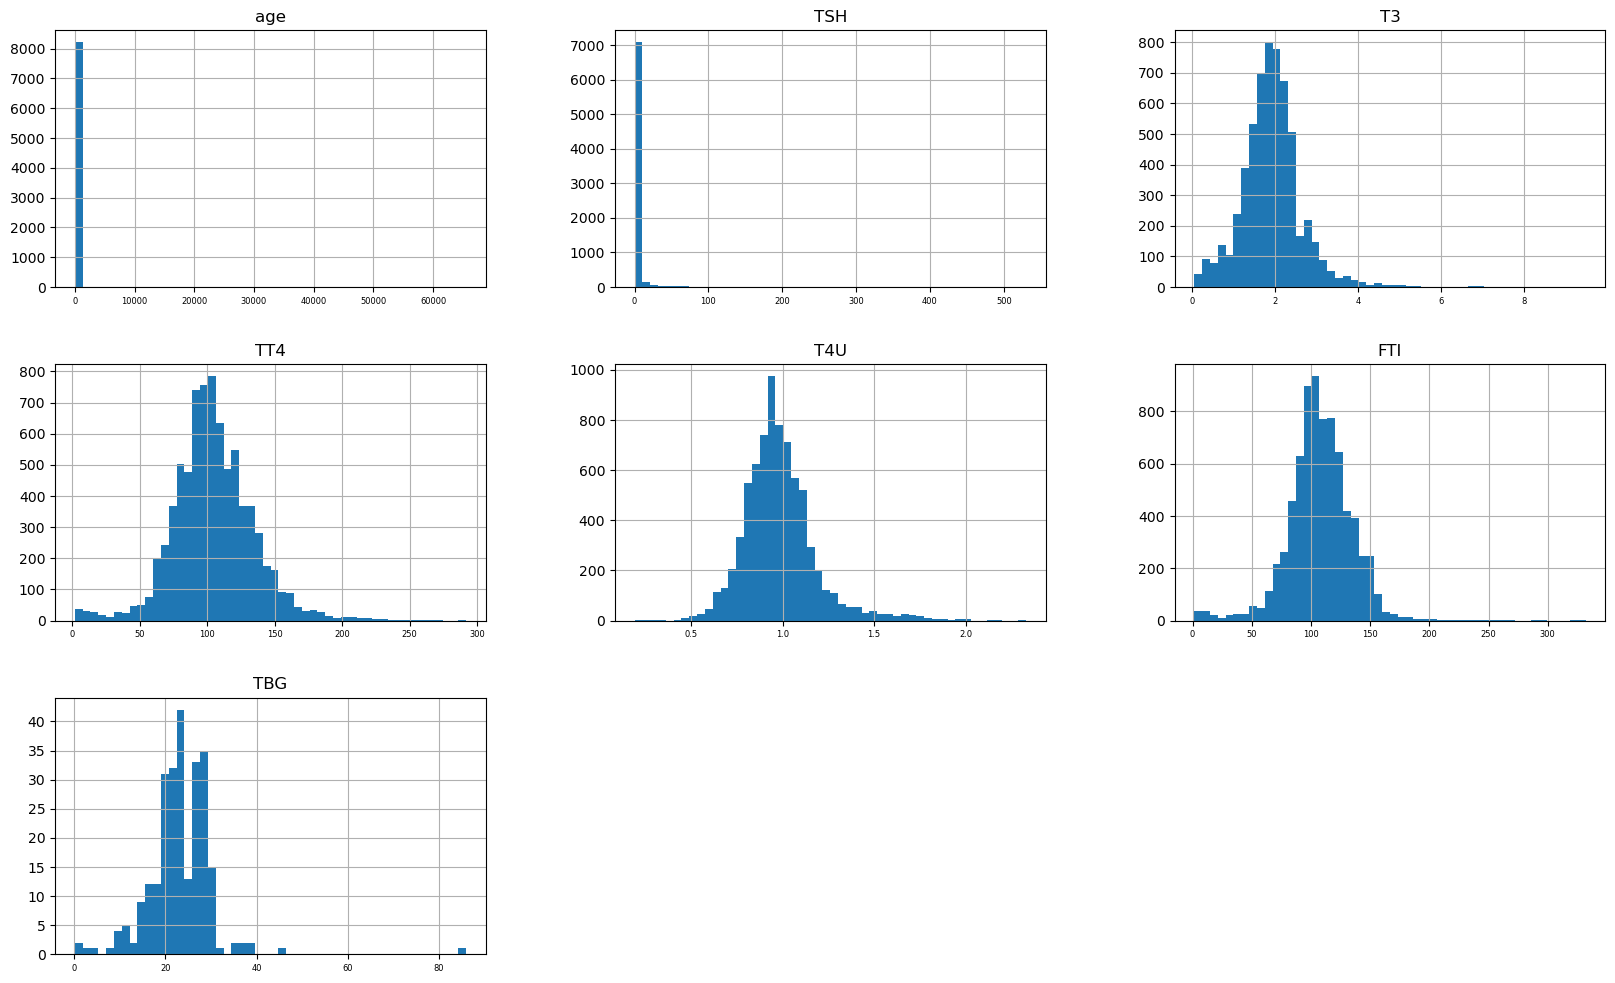

In [9]:
import matplotlib.pyplot as plt

_ = df.hist(bins=50, figsize=(20, 12), xlabelsize=6) 

Vemos que las principales variables numéricas tienen en general distribuciones normales. Lo cual es esperable en métricas de pruebas médicas donde la mayor parte de muestras son negativas: se trata de una representación de la población, *normalmente* los pacientes tendrán metricas en el torno a la media, y las medidas extremas son poco frecuentes y a menudo serán indicadores de enfermedad.

Esto hace que la estrategia de imputación de valores faltantes por la media o la mediana sea bastante buena, ya que los valores imputados serán valores cercanos a la media de la población, y por lo tanto no sesgarán el modelo. En particular, para las variables T3, TT4, T4U y FTI, la distribución es bastante simétrica y no tiene outliers, por lo que la media y la mediana son muy similares.

TSH merecería un tratamiento especial, ya que tiene una distribución bastante asimétrica y algunos valores extremadamente altos, por lo que se podría considerar la posibilidad de transformar la variable para que sea más simétrica.

Algo similar sucede con la edad, que tiene una distribución bastante asimétrica y algunos valores extremadamente altos. Sin embargo, aquí tenemos claro que ciertos valores son absurdos.


### Tratamiento de edad

In [10]:
# Values of age over 100
df[df['age'] > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
2976,455,F,f,f,f,f,f,f,f,f,...,f,f,f,1.10,2.0,118.0,1.13,104.0,NaN,negative
5710,65511,M,f,f,f,f,f,f,f,f,...,f,f,f,0.38,2.0,113.0,1.08,104.0,NaN,negative
6392,65512,M,f,f,f,f,f,f,f,f,...,f,f,f,0.03,2.8,112.0,0.84,133.0,NaN,negative
8105,65526,F,f,f,f,f,f,f,f,f,...,f,f,f,1.50,NaN,132.0,1.02,129.0,NaN,negative


<Axes: >

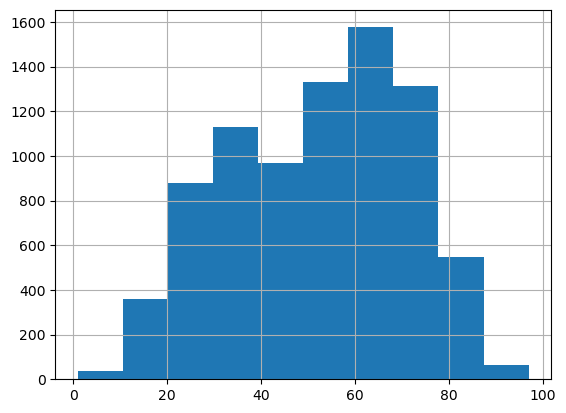

In [11]:
df[df['age'] < 100]['age'].hist()

Vemos que existen 4 filas con valores de edad absurdos que serán considerados por tanto errores de entrada de datos, por lo que se tratara como valores faltantes y se imputarán. Una vez eliminados estos valores, la distribución de la edad es bastante simétrica y no tiene outliers.


### Tratamiento de TSH

Por otra parte, TSH tiene la mayor parte de sus valores en el rango de 0 a 10, pero también tiene algunos valores extremadamente altos. Por lo tanto, se considerará la posibilidad de mantener estos valores extremos en el conjunto de datos. La distribución es muy asimétrica, por lo que se podría considerar la posibilidad de transformar la variable para que sea más simétrica.

> TODO: Valores superiores a 100 deberían tratarse como errores de entrada de datos.

<Axes: >

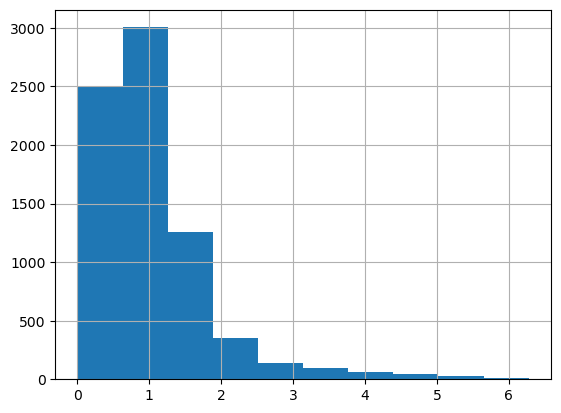

In [12]:
import numpy as np
np.log1p(df['TSH']).hist()

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["target_enc"]=le.fit_transform(df["target"])

corr_matrix = df.corr(numeric_only=True)
corr_matrix["target_enc"].sort_values(ascending=False, key=np.abs)

target_enc    1.000000
T3            0.286759
TBG          -0.192863
TSH          -0.183578
FTI           0.180041
TT4           0.131691
T4U          -0.060922
age           0.006814
Name: target_enc, dtype: float64